## Tutorial - example of all metrics

This notebook shows the functionality of the different tests.

In [ ]:
# Mount Google Drive. #remove
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

# Install packages. #remove
!pip install captum opencv-python torch==1.8.0 torchvision==0.9.0

# Imports general.
import sys
import warnings
import gc
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import captum
from torchvision import transforms
from tqdm import tqdm
from captum.attr import *
import random

# Import package.
sys.path.append('/content/drive/MyDrive/Projects/xai_quantification_toolbox')
import quantus

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

     |████████████████████████████████| 1.4 MB 8.9 MB/s 
     |████████████████████████████████| 735.5 MB 13 kB/s 
     |████████████████████████████████| 17.3 MB 41 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.8.0 which is incompatible.


In [ ]:
#import gc
gc.collect()
torch.cuda.empty_cache()

NameError: ignored

### Load model, data and attributions.

In [ ]:
# Load pre-trained ResNet18 model.
model = torchvision.models.resnet18(pretrained=True)
model.eval()

# Load test data and loaders.
test_set = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/imagenet_images',
                                            transform=transforms.Compose([transforms.Resize(256),
                                                                          transforms.CenterCrop((224, 224)),
                                                                          transforms.ToTensor(),
                                                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=24)

# Evaluate model performance.
#predictions, labels = evaluate_model(model.to(device), data=test_loader, device=device)
#print(f"\nModel test accuracy: {(100 * score_model(predictions, labels)):.2f}%")

In [ ]:
# Load data, targets and attributions.
method = "Gradient"
x_batch, y_batch = iter(test_loader).next()
a_batch = explain(model.to(device), x_batch.to(device), y_batch.to(device), explanation_func=method)

# Plot some explanations!
for i in range(10, 12):
    plt.imshow(denormalize_image(x_batch.cpu().data[i]).transpose(0, 1).transpose(1, 2))
    plt.axis("off")
    plt.show()
    plt.imshow(a_batch.cpu().data[i], cmap="seismic")
    plt.colorbar()
    plt.axis("off")
    plt.show()

### Robustness tests

In [ ]:
# One-liner to measure robustness of provided attributions.
rt = RobustnessTest(**{
    "similarity_func": lipschitz_constant,
    "perturb_func": gaussian_noise,
})

print(rt.README)

rt(model=model, 
   x_batch=x_batch.cpu().numpy(), 
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": method, "device": device})


        - What the output mean

        - What a high versus low value indicates

        - Assumptions (to be concerned about)

        - Further reading

        Parameters
        ----------
        model
        x_batch
        y_batch
        a_batch
        kwargs

        Returns
        -------

        
None


[197.63624435725492,
 188.49155250546292,
 100.9557658377382,
 179.70828926294985,
 288.43885941687546,
 147.53582879347616,
 138.19506743336703,
 142.85241653487907,
 258.9642667429549,
 97.10097928433122,
 177.94381525611198,
 92.846628702717,
 266.65153397121554,
 113.63763430095904,
 128.48337932295888,
 146.938965849913,
 279.2035331665891,
 152.29509764704264,
 145.1582943223345,
 340.3033904554397,
 119.6011567015214,
 132.5075432685317,
 68.7718091668208,
 102.1641587666222]

In [ ]:
# One-liner to measure continuity of provided attributions.
continuity_test = ContinuityTest(**{
    "similarity_func": correlation_spearman,
    "perturb_func": translation_x_direction,
    "nr_patches": 4,
    "nr_steps": 10,
    "img_size": 224,
})
scores = continuity_test(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(),
   a_batch=a_batch.cpu().numpy(),
   **{"explanation_func": method, "device": device})

print(f"Continutity correlation score: {continuity_test.continutity_correlation_score:.4f}")

scores

Continutity correlation score: 0.6711


{0: {0: [386.07427978515625,
   378.8328857421875,
   323.25469970703125,
   191.7088623046875,
   148.72665405273438,
   109.90787506103516,
   88.72872924804688,
   81.98219299316406,
   78.73688507080078,
   68.29515838623047],
  1: [388.72503662109375,
   444.39190673828125,
   459.4841003417969,
   442.27264404296875,
   475.0151062011719,
   455.3834228515625,
   493.08404541015625,
   356.1865234375,
   310.1424560546875,
   142.26150512695312],
  2: [305.780029296875,
   274.53570556640625,
   245.7594451904297,
   185.32469177246094,
   236.49644470214844,
   118.130859375,
   89.27313232421875,
   93.67514038085938,
   93.01911926269531,
   69.37049865722656],
  3: [244.29136657714844,
   288.864013671875,
   288.78369140625,
   359.8026428222656,
   386.4769287109375,
   361.30975341796875,
   444.7549743652344,
   556.6298217773438,
   351.7783203125,
   313.3381042480469],
  4: [15.051656723022461,
   12.26597785949707,
   12.799393653869629,
   11.450897216796875,
   10.1

In [ ]:
# One-liner to measure input independence of provided attributions.
scores = InputIndependenceRate(**{
    "similarity_func": abs_difference,
    "perturb_func": optimization_scheme, # TODO.
    "perturb_std": 0.01,
    "threshold": 0.025, # 0.1
})(model=model, 
   x_batch=x_batch.cpu().numpy(), 
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": methodevice": device})

scores

1.0

In [ ]:
# One-liner to measure local lipschitz constant of provided attributions.
scores = LocalLipschitzEstimate(**{
    "similarity_func": lipschitz_constant,
    "perturb_func": gaussian_noise,
    "norm_numerator": distance_euclidean,
    "norm_denominator": distance_euclidean,
    "perturb_std": 0.1,
    "nr_steps": 10, #200
})(model=model, 
   x_batch=x_batch.cpu().numpy(), 
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": method, "device": device})

scores

[23.514091186720364,
 30.375872616974682,
 45.04307967456061,
 30.44654352496413,
 23.623734466910584,
 15.640783549600796,
 26.146391918197136,
 26.600307333730072,
 44.15994701100762,
 28.217126894595552,
 28.068114413919677,
 35.23281737576764,
 27.117401830344342,
 46.56626638674991,
 30.16407201266697,
 26.51188727874495,
 21.09053143969113,
 19.544432898049116,
 19.799670415440165,
 58.99666987926437,
 41.813994162756465,
 23.700393433739105,
 29.31097230894623,
 20.00698006568726]

In [ ]:
# One-liner to measure sensitivity max of provided attributions.
scores = SensitivityMax(**{
    "similarity_func": difference,
    "perturb_func": uniform_sampling,
    "norm_numerator": fro_norm,
    "norm_denominator": fro_norm,
    "perturb_radius": 0.2,
    "nr_steps": 10,
})(model=model, 
   x_batch=x_batch.cpu().numpy(), 
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": method "device"": device})
scores

[0.015217264,
 0.020530399,
 0.022441331,
 0.021143181,
 0.018760437,
 0.010292453,
 0.018722871,
 0.018202571,
 0.024813404,
 0.019347936,
 0.01919846,
 0.02336814,
 0.014008923,
 0.04217343,
 0.027502604,
 0.013423934,
 0.011428912,
 0.011496279,
 0.01886074,
 0.033394434,
 0.032643806,
 0.015666362,
 0.014373922,
 0.009866114]

### Faithfulness tests

In [ ]:
# One-liner to for faithfulness base class of provided attributions.
scores = FaithfulnessCorrelation(**{
    "subset_size": 224,
})(model=model, 
   x_batch=x_batch.cpu().numpy(), 
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": method, "device": device})

scores

[-0.6381189714518398,
 0.4868869552467518,
 -0.3387196896681008,
 -0.5127285564076277,
 0.40672033831786947,
 -0.17461439477621776,
 -0.49446020498110715,
 0.7226852905118236,
 -0.11039935390020594,
 -0.29194379378037305,
 0.5466790765426648,
 0.09836188043089787,
 -0.7409646234863013,
 -0.26678231863605045,
 0.30288298525517077,
 0.43561752613425053,
 0.3919227166472298,
 -0.7703423221263281,
 0.04562611863328736,
 0.2674407300258304,
 0.4045919064605596,
 0.5851322938734074,
 -0.3397078047946692,
 -0.47100141085309]

In [ ]:
# One-liner to measure faithfulness estimate of provided attributions.
scores = FaithfulnessEstimate(**{
    "perturb_func": baseline_replacement_by_indices,
    "similarity_func": correlation_pearson,
    "perturb_baseline": 0.0,  
    "pixels_in_step": 28,
})(model=model,
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": methodevice": device})

scores

[-0.4881478276923199,
 0.420197123141877,
 -0.2422078107439273,
 -0.6248737733390191,
 0.40985019232073305,
 -0.16087289723673248,
 -0.4092686174734576,
 0.4949946685863843,
 -0.1547495037186185,
 -0.25373450357306737,
 0.3592922604981258,
 0.031557575396743316,
 -0.5277802983731348,
 -0.2126617413071898,
 0.37667238381855006,
 0.2912363662733971,
 0.2423356393063364,
 -0.6240566521866351,
 -0.23288459223606728,
 0.1669467040276532,
 0.3323789433102261,
 0.5037852646483032,
 -0.06856965838020462,
 -0.27903523489627813]

In [ ]:
# One-liner to measure infidelity of provided attributions.
scores = Infidelity(**{
    "perturb_func": baseline_replacement_by_patch,
    "similarity_func": mse,
    "perturb_baseline": "black",  
    "perturb_patch_sizes": [14, 28] #list(np.arange(10,30)),
})(model=model, 
  x_batch=x_batch.cpu().numpy(), 
  y_batch=y_batch.cpu().numpy(), 
  a_batch=a_batch.cpu().numpy(), 
  **{"explanation_func": method, "device": device})

scores

[302.9967222378978,
 465.74117300949683,
 959.2037175298267,
 793.409036333058,
 324.71202624874445,
 213.9213152726027,
 334.07924467307726,
 405.0218019419587,
 882.7419984430978,
 522.3432744124167,
 487.44355714506014,
 543.1775324710296,
 435.58439309133644,
 1099.2801651558668,
 748.6690468580862,
 286.5262370397003,
 274.36140584486867,
 217.64150268875164,
 314.22844424401984,
 1817.84748637369,
 859.9777030633475,
 389.44526416913607,
 431.54501949544647,
 163.1301690565748]

In [ ]:
# One-liner to measure montonicity metric of provided attributions.
scores = MonotonicityMetric(**{
    "perturb_func": baseline_replacement_by_indices,
    "similarity_func": correlation_spearman,
    "perturb_baseline": 0.0,
    "pixels_in_step": 28,
})(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(),
   **{"explanation_func": methodevice": device})

scores

[0.46618477999173613,
 -0.2575878414852677,
 0.29112249198963885,
 0.34877927087795707,
 -0.15807490446346423,
 0.07990982661733582,
 0.38810073700401676,
 -0.40216191369314097,
 0.1034217465136846,
 0.18514813850231018,
 -0.4901699193133095,
 0.05105525825137548,
 0.5345673814022244,
 0.14913360701306339,
 -0.09159045908498038,
 -0.3751411664770604,
 -0.30708400134456226,
 0.6081071744034756,
 -0.023862776070711796,
 -0.0842427010466073,
 -0.32901279459976324,
 -0.5636926353895769,
 0.041313822416486644,
 0.23965197755229842]

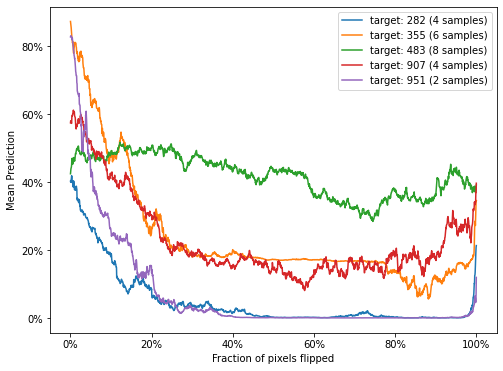

In [ ]:
# One-liner to conduct pixel-flipping experiment of provided attributions.
scores = PixelFlipping(**{
    "perturb_func": baseline_replacement_by_indices,
    "perturb_baseline": "black",
    "pixels_in_step": 28,
})(model=model,
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(),
   a_batch=a_batch.cpu().numpy(),
   **{"explanation_func": method, "device": device})

# Plot example!
plot_pixel_flipping_experiment(y_batch, scores)

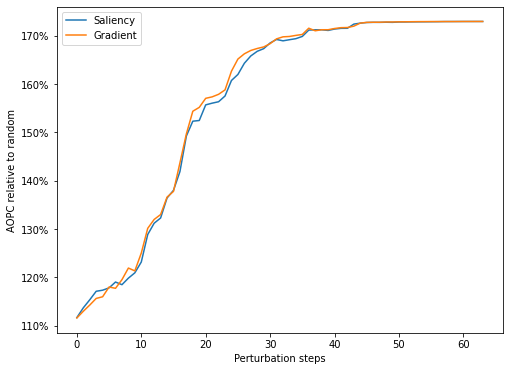

In [ ]:
# One-liner to measure faithfulness estimate of provided attributions.
region_perturb_test = RegionPerturbation(**{
    "perturb_func": baseline_replacement_by_patch,
    "perturb_baseline": "uniform",  
    "patch_size": 28,
    "regions_evaluation": 100,
    "random_order": False})

scores = {method: region_perturb_test(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": method, "device": device}) for method in ["Saliency", "Gradient"]}

# Plot example!
plot_region_perturbation_experiment(scores)

AUC: 8412.1977


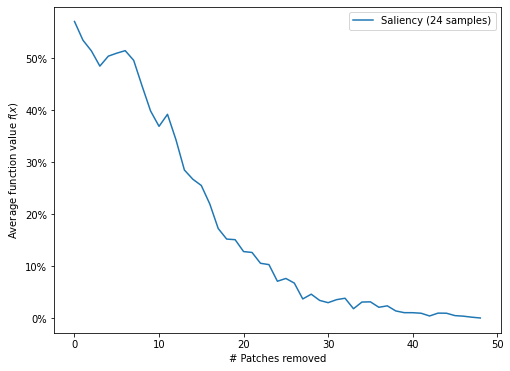

In [ ]:
# One-liner to measure faithfulness estimate of provided attributions.
selectivity_test = Selectivity(**{
    "perturb_func": baseline_replacement_by_patch,
    "perturb_baseline": "black",  
    "patch_size": 32
})
scores = selectivity_test(model=model, 
                 x_batch=x_batch.cpu().numpy(),
                 y_batch=y_batch.cpu().numpy(), 
                 a_batch=a_batch.cpu().numpy(), 
                 **{"explanation_func": methodevice": device})
print(f"AUC: {selectivity_test.area_under_the_curve:.4f}")

# Plot example!
plot_selectivity_experiment({"Saliency": scores})

In [ ]:
# One-liner to measure faithfulness estimate of provided attributions.
scores = SensitivityN(**{
    "perturb_func": baseline_replacement_by_indices,
    "similarity_func": correlation_pearson,
    "n_max_percentage": 0.8,
    "perturb_baseline": "uniform",  
    "pixels_in_step": 128,
})(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": method, "device": device})

scores
# Plot example!
#plot_selectivity_experiment(scores)

### Complexity tests

In [ ]:
# One-liner to measure faithfulness estimate of provided attributions.
scores = SparsenessTest()(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": method, "device": device})

scores

[0.4068544910493193,
 0.40403445669812693,
 0.481418430522996,
 0.43348663807612225,
 0.4469029816861512,
 0.4869256708564608,
 0.4346094099015184,
 0.44411300714858515,
 0.41899337281779514,
 0.43024956158126776,
 0.5012424486664208,
 0.4757315614566706,
 0.40789886602229375,
 0.4213190000559146,
 0.5673514217398928,
 0.3811969144468322,
 0.509078128818867,
 0.47547261337752417,
 0.42619295887745434,
 0.4507217762296288,
 0.4047523814239077,
 0.4293180322968817,
 0.4595081011092839,
 0.4814590122244766]

In [ ]:
# One-liner to measure faithfulness estimate of provided attributions.
scores = ComplexityTest()(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": method, "device": device})

scores

### Assert tets

In [ ]:
# One-liner to measure faithfulness estimate of provided attributions.
scores = CompletenessTest(**{"output_transformation_func": lambda x: x})(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": method, "device": device})

scores

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

### Others

In [ ]:
### Option 1. Evaluate the robustness of attributions in one line of code.

# Provide notebooks for the different use cases: compare models, XAI methods, different measures
# ...


### Option 2. Evaluate the robustness of provided attributions while enjoying more functionality of Quantifier and Plotting.

# Specify the tests.
tests = [RobustnessTest(**{
    "similarity_function": similarity_fn,
    "perturbation_function": gaussian_blur,
}) for similarity_fn in [lipschitz_constant, distance_euclidean, cosine]]

# Load attributions of another explanation method.
a_batch_intgrad = IntegratedGradients(model).attribute(inputs=x_batch, targets=y_batch)

# Init the quantifier object.
quantifier = Quantifier(measures=tests, io_object=h5py.File("PATH_TO_H5PY_FILE"), checkpoints=..)

# Score the tests.
results = [quantifier.score(model=model, x_batch=x_batch, y_batch=y_batch, a_batch=a_batch)
           for a_batch in [a_batch_saliency, a_batch_intgrad]]

# Plot Saliency vs Integrated Gradients.
Plotting(results, show=False, path_to_save="PATH_TO_SAVE_FIGURE")